# Libraries

In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Importing and Exploring the Dataset

In [3]:
data=pd.read_csv('mydata.csv',encoding='latin-1')
data.head(n=5)

,Heat_Related_Illness,CCUpdates
0,False,{1};Chest Pain;|{2};Fatigue;
1,False,{1};left 5th finger dislocation;
2,False,{1};NAUSEA CHEST PRESSURE HEADACHE;
3,False,{1};pt. reports I have another bowel blockage....
4,False,{1};;|{2};Dizziness;


## Convert the logical variable to a categorical variable
0 for false and 1 for true

In [4]:
data['Heat_Related_Illness']=data['Heat_Related_Illness']*1

# Distribution true/false plots


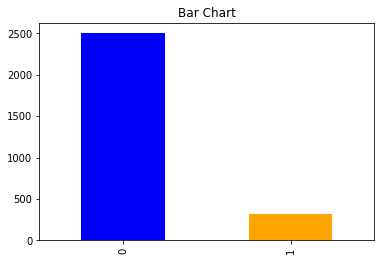

In [5]:
count_Class=pd.value_counts(data["Heat_Related_Illness"],sort=True)
count_Class.plot(kind='bar',color=["blue","orange"])
plt.title("Bar Chart")
plt.show()

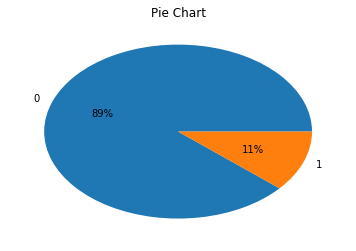

In [6]:
count_Class.plot(kind='pie',autopct='%1.0f%%')
plt.title('Pie Chart')
plt.ylabel('')
plt.show()

# Text Analytics

We want to find the fewquencies of words in the chief complaints of true and false heat related illness. The words of the chief complaints will be model features.

We use the function Counter.

In [7]:
count1=Counter("".join(data[data['Heat_Related_Illness']==0]["CCUpdates"]).split()).most_common(20)
df1=pd.DataFrame.from_dict(count1)
df1=df1.rename(columns={0: "False", 1: "count"})
count2=Counter("".join(data[data['Heat_Related_Illness']==1]['CCUpdates']).split()).most_common(20)
df2=pd.DataFrame.from_dict(count2)
df2=df2.rename(columns={0: "True", 1: "count"})

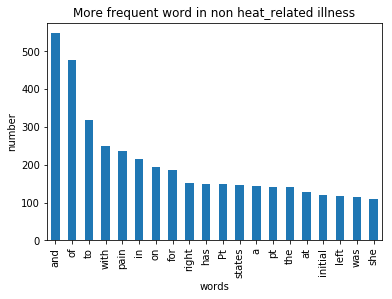

In [8]:
df1.plot.bar(legend=False)
y_pos=np.arange(len(df1["False"]))
plt.xticks(y_pos,df1["False"])
plt.title("More frequent word in non heat_related illness")
plt.xlabel('words')
plt.ylabel('number')
plt.show()

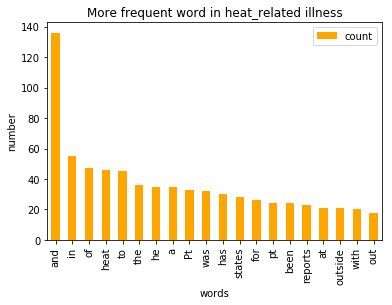

In [9]:
df2.plot.bar(legend=True,color='orange')
y_pos=np.arange(len(df2["True"]))
plt.xticks(y_pos,df2["True"])
plt.title("More frequent word in heat_related illness")
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### We can see that the majority of frequent words in both classes are stop words such as 'and', 'to', 'of' and so on. 
With stop words we refer to the most common words in a language, there is no universal list of stop words.


# Feature Extraction

### We remove the stop words in order to improve prediction accuracy.

In [10]:
f=feature_extraction.text.CountVectorizer('english')
X=f.fit_transform(data['CCUpdates'])
np.shape(X)

(2819, 3438)

# Predictive Analysis

### The variable Heat_Related_Illness is already a binary variable. We then spilt the data set in training set and test set.

In [11]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,data['Heat_Related_Illness'],test_size=0.25,random_state=123)
print([np.shape(y_train),np.shape(y_test)])

[(2114,), (705,)]


### Multinomial Naive Bayes Classifier

We train different Bayes models using various regularization parameter alpha.

We evaluate the accuracy, sensitivity (recall), specificity, and precision.

In [12]:
list_alpha=np.arange(1/100000,20,0.11)

In [13]:
score_train=np.zeros(len(list_alpha))
score_test=np.zeros(len(list_alpha))
recall_test=np.zeros(len(list_alpha))
precision_test=np.zeros(len(list_alpha))
count=0
for alpha in list_alpha:
    bayes=naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train,y_train)
    score_train[count]=bayes.score(X_train,y_train)
    score_test[count]=bayes.score(X_test,y_test)
    recall_test[count]=metrics.recall_score(y_test,bayes.predict(X_test))
    precision_test[count]=metrics.precision_score(y_test,bayes.predict(X_test))
    count=count+1

In [14]:
matrix=np.matrix(np.c_[list_alpha,score_train,score_test,recall_test,precision_test])
models=pd.DataFrame(data=matrix,columns=
                   ['alpha','Train Accuracy','Test Accuracy','Test Sensitivity','Test Precision'])
#models.head(n=4)

### I select the model with the highest sensitivity.

In [15]:
best_index = models['Test Sensitivity'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha               0.110010
Train Accuracy      0.967360
Test Accuracy       0.879433
Test Sensitivity    0.675000
Test Precision      0.477876
Name: 1, dtype: float64

### Confusion matrix with Naive Bayes Classifier

In [16]:
m_confusion_test=metrics.confusion_matrix(y_test,bayes.predict(X_test))
pd.DataFrame(data=m_confusion_test,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,566,59
Actual 1,26,54


# Support Vector Machine

We apply the support vector machine model with the gaussian kernel.

We train different models with various regularization parameter C.

We evaluate the accuracy, sensitivity (recall), specificity, and precision of the model with test set.

In [17]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

We look at the first 5 learning models and their metrics.

In [18]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Sensitivity', 'Test Precision'])
models.head(n=5)

,C,Train Accuracy,Test Accuracy,Test Sensitivity,Test Precision
0,500.0,0.967360,0.943262,0.5625,0.900000
1,600.0,0.968307,0.943262,0.5625,0.900000
2,700.0,0.970672,0.941844,0.5500,0.897959
3,800.0,0.972091,0.940426,0.5625,0.865385
4,900.0,0.973510,0.937589,0.5625,0.833333


### Select the model with the highest sensitivity.

In [19]:
best_index = models['Test Sensitivity'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                   1700.000000
Train Accuracy         0.980132
Test Accuracy          0.927660
Test Sensitivity       0.587500
Test Precision         0.723077
Name: 12, dtype: float64

### Confusion matrix with support vector machine classifier.

In [20]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,607,18
Actual 1,33,47
